The goal of this notebook is to attempt to predict the causes of wildfires given data on its location, its size, and the discovery date. I will use the previous notebook on the exploratory analysis to select the variables that will be used in different machine learing algorithms.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Connect to the database and import the table 'Fires'
import os
import sqlite3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


conn = sqlite3.connect('/kaggle/input/us-wildfire-records-6th-edition/data.sqlite') 
df = pd.read_sql_query('SELECT * FROM Fires;', con=conn)

# Close connection
conn.close()

# Select only columns of interest
col_of_interest = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE' , 'LONGITUDE' , 'STATE']
df = df[col_of_interest].set_index('OBJECTID', verify_integrity = True)

# Rename the columns and the index
df = df.rename(columns = {'FIRE_YEAR':'fire_year',
                         'DISCOVERY_DATE':'disc_date',
                         'DISCOVERY_DOY':'disc_doy',
                         'NWCG_GENERAL_CAUSE':'cause',
                         'FIRE_SIZE' : 'fire_size',
                         'FIRE_SIZE_CLASS' : 'fire_class',
                         'LATITUDE':'latitude',
                         'LONGITUDE':'longitude',
                         'STATE':'state'}).rename_axis('id')

# Convert the columns 'disc_date' in datetime format and add a colmun with the month
df['disc_date'] = pd.to_datetime(pd.to_datetime(df['disc_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df.insert(3, 'disc_month', df['disc_date'].dt.month)
df.insert(4, 'disc_day', df['disc_date'].dt.day_name())

# Define a new column 'origin'
map_cause = {'Power generation/transmission/distribution':'Accidental',
            'Natural':'Natural',
            'Debris and open burning':'Accidental',
            'Missing data/not specified/undetermined':'Undefined',
            'Recreation and ceremony':'Accidental',
            'Equipment and vehicle use':'Accidental',
            'Arson/incendiarism':'Criminal',
            'Fireworks':'Accidental',
            'Other causes':'Accidental',
            'Railroad operations and maintenance':'Accidental',
            'Smoking':'Accidental',
            'Misuse of fire by a minor':'Accidental',
            'Firearms and explosives use':'Accidental'}

df['origin'] = df['cause'].map(map_cause)

# For the analysis, we focus on the contiguous USA and define four main geographic area
df = df.loc[(df['latitude']>=25) & (df['latitude']<=50)]

df.head()

/kaggle/input/us-wildfire-records-6th-edition/_variable_descriptions.csv
/kaggle/input/us-wildfire-records-6th-edition/data.sqlite
/kaggle/input/us-wildfire-records-6th-edition/data.csv


,fire_year,disc_date,disc_doy,disc_month,disc_day,cause,fire_size,fire_class,latitude,longitude,state,origin
id,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,Power generation/transmission/distribution,0.10,A,40.036944,-121.005833,CA,Accidental
2,2004,2004-05-12,133,5,Wednesday,Natural,0.25,A,38.933056,-120.404444,CA,Natural
3,2004,2004-05-31,152,5,Monday,Debris and open burning,0.10,A,38.984167,-120.735556,CA,Accidental
4,2004,2004-06-28,180,6,Monday,Natural,0.10,A,38.559167,-119.913333,CA,Natural
5,2004,2004-06-28,180,6,Monday,Natural,0.10,A,38.559167,-119.933056,CA,Natural


# 1. Selection of variables and feature engineering

We know that the cause of wildfire varies largely across states. For the spatial dimension, I will use latitude and longitude coordinates because they provide a finest resolution than states.

For the temporal dimension, I will use day of week, the month and, of course, the year. For month, I will use them their names rather than numbers to avoid to have a hirarchical relationship between them.



In [2]:
df['disc_month'] = df['disc_date'].dt.month_name()

Finally, I have to decide either 'fire_size' or 'fire_class' to be used.

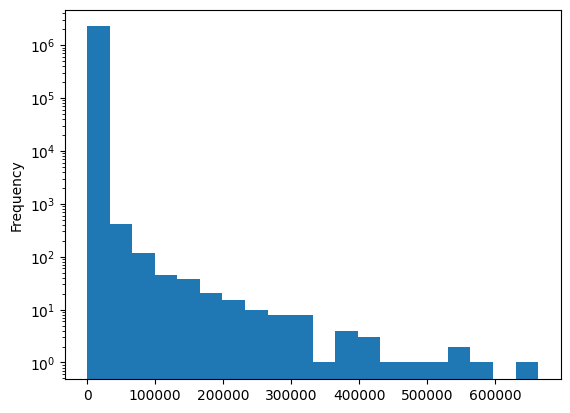

In [3]:
df['fire_size'].plot(kind = 'hist', bins = 20, log = True);

The distribution of 'fire_size' is unbalanced toward small values. As this could be problematic for the machine learing, I will use 'fire_class' instead.

In [4]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

# target versus features
labels = df['cause']
features = df.drop(columns = ['disc_date', 'disc_doy', 'cause', 'fire_size', 'state', 'origin'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# Encoding the target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Encoding features
num_features = ['fire_year', 'latitude', 'longitude']
cat_features = ['disc_month', 'disc_day', 'fire_class']

num_train = X_train[num_features]
num_test = X_test[num_features]
cat_train = X_train[cat_features]
cat_test = X_test[cat_features]

ode = OrdinalEncoder()
cat_train_encoded = ode.fit_transform(cat_train)
cat_test_encoded = ode.transform(cat_test)

X_train = np.concatenate([num_train, cat_train_encoded], axis=1)
X_test = np.concatenate([num_test, cat_test_encoded], axis=1)

print("Train subset dimensions:", X_train.shape)
print("Test subset dimensions:", X_test.shape)

Train subset dimensions: (1804724, 6)
Test subset dimensions: (451181, 6)


# 2. Random Forest

I will first train a Random Forest algorithm. One particularity of this algorithm is that is less sensitive to the normalisation of numeric data compared to others, that is an advantage here considering that we are dealing with spatial and temporal data.

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_jobs=-1, min_samples_leaf=10, max_depth=120, n_estimators=50)
clf_rf.fit(X_train, y_train)

print('Score on train subset:', clf_rf.score(X_train, y_train))
print('Score on test subset:', clf_rf.score(X_test, y_test))

Score on train subset 0.6422200846223578
Score on test subset 0.5689025025433252
141.01824712753296 secondes.


In [6]:
from sklearn.metrics import classification_report

y_pred_rf = clf_rf.predict(X_test)

print(classification_report(y_test, 
                            y_pred_rf,
                            target_names=le.inverse_transform(np.arange(labels.nunique()))
                           )
     )

                                            precision    recall  f1-score   support

                        Arson/incendiarism       0.57      0.49      0.53     64177
                   Debris and open burning       0.51      0.73      0.60    106931
                 Equipment and vehicle use       0.45      0.21      0.29     37887
               Firearms and explosives use       0.94      0.35      0.51       505
                                 Fireworks       0.57      0.29      0.39      3751
   Missing data/not specified/undetermined       0.60      0.69      0.64    112527
                 Misuse of fire by a minor       0.47      0.08      0.13     13157
                                   Natural       0.68      0.81      0.74     64200
                              Other causes       0.45      0.02      0.04      2051
Power generation/transmission/distribution       0.49      0.02      0.04      6404
       Railroad operations and maintenance       0.51      0.39      0.44  

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


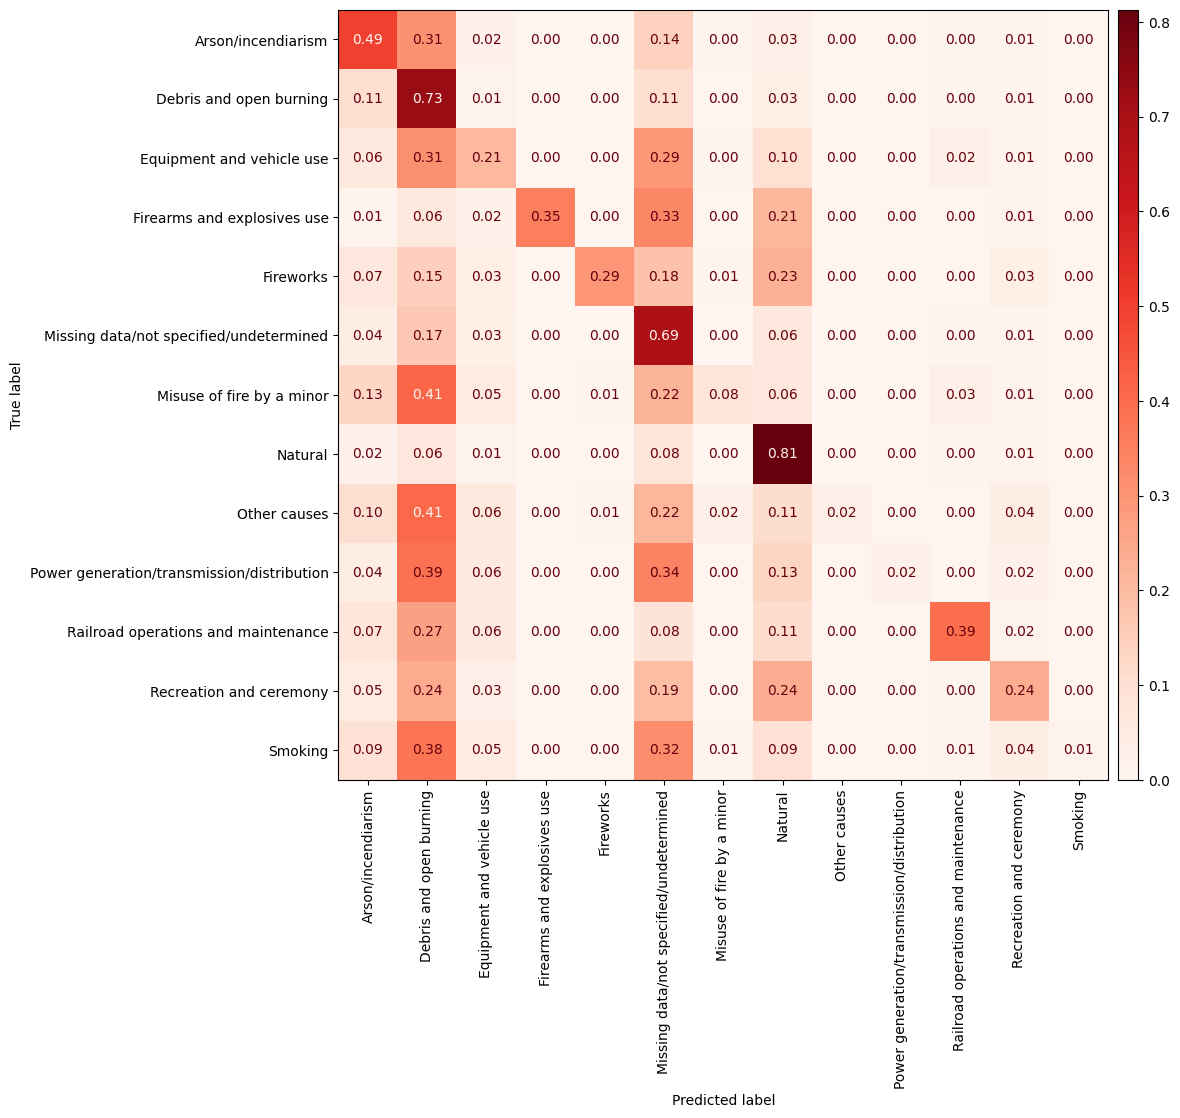

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))

cmp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, 
                                              display_labels = le.inverse_transform(np.arange(labels.nunique())),
                                              normalize = 'true',
                                              xticks_rotation='vertical',
                                              cmap=plt.cm.Reds, 
                                              values_format = '.2f', 
                                              ax=ax,
                                              colorbar=False)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax);

Conclusion:


I also aimed to optimize this classifier, using GridSearchCV, and found the following parameters : [min_samples_leaf=10, max_depth=120, n_estimators=320, criterion = 'entropy']. Yet, the gain in terms of prediction was only about 0.2-0.3% but the time of execution increased largely much from minutes to hours, making this optimization not worthy.

In [10]:
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler

# Encoding numeric data 
scaler = MinMaxScaler()
num_train_scaled = scaler.fit_transform(num_train)
num_test_scaled = scaler.transform(num_test)

X_train_scaled = np.concatenate([num_train_scaled, cat_train_encoded], axis=1)
X_test_scaled = np.concatenate([num_test_scaled, cat_test_encoded], axis=1)

startTime = time.time()
knn = neighbors.KNeighborsClassifier(n_jobs=-1, metric='manhattan', n_neighbors=8)
knn.fit(X_train_scaled, y_train)
print(time.time() - startTime)

print('Score on train subset:', knn.score(X_train_scaled, y_train))
print('Score on test subset:', knn.score(X_test_scaled, y_test))

4.896232843399048
Score on train subset 0.5881569702624889
Score on test subset 0.49575669188197197


In [11]:
startTime = time.time()
knn_unscaled = neighbors.KNeighborsClassifier(n_jobs=-1, metric='manhattan', n_neighbors=8)
knn_unscaled.fit(X_train, y_train)

print('Score on train subset:', knn_unscaled.score(X_train, y_train))
print('Score on test subset:', knn_unscaled.score(X_test, y_test))
print(time.time() - startTime)


Score on train subset 0.6105349072766806
Score on test subset 0.5229054414968716
261.2463343143463
